<a href="https://colab.research.google.com/github/CrisVolcano/Introducci-n-GEE-con-Python/blob/main/taller_gee_geemap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

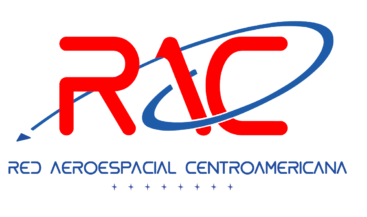

> Pre-entrenamiento al curso de Radar de Apertura Sintética 



# Manual introductorio a Google Earth Engine con Geemap

#### Compilado por el equipo RAC en noviembre de 2022

* Cristian Aguilar-Barboza
* María José Molina Montero
* Jesús Cespedes Rivera


# Primeros pasos en python

In [ ]:
#  Iniciemos por el popular Hola mundo utilizando la función print()

#print('hola mundo')

#También podemos definir una variable
#las variables se usan para almacenar objetos
#msg = 'Hola mundo!'
#print(msg)

#Listas
#mi_lista = ['hola', 'RAC', 'Centroamérica']
#print(mi_lista[2])


#diccionarios 
#el_numero= 23
# Las llaves (o corchetes) pueden usarse para definir diccionarios (pares clave:valor)
#mi_dic = {'comida': 'pan', 'color': 'rojo', 'número': el_numero}
#print(mi_dic['número']);

#Las funciones pueden definirse como una forma de reutilizar el código y facilitar su lectura
#def mi_funcion_hola(string):
#  return '¡Hola ' + string + '!' 
#print(mi_funcion_hola('RAC'))

# Instalar y cargar librerías





1.   Instale librería geemap  https://geemap.org/
2.   Carge librerías de interés
3. Inicie sesión en GEE.







In [ ]:
 !pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importar librerias
import geemap
import ee


In [ ]:
# Iniciar Sesión en GEE
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Mm_fAIKgRFRPxU8GvHn1hv9VL5COhc14IdgHnq5Tajs&tc=AuLoG-Bg68g0AIW6uLNRW29OH5vyCYdk3IbHxw1JoQI&cc=NrKqQL1n04r_SC1_7Ijnmq3sBfW__zU9Qlt3Q4KT1tQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfgeXvtfzWeeBwpjrQV-dLpR0jrJ8-ciTzrClvOFVC_87D2025sCadwtULk

Successfully saved authorization token.


In [ ]:
#Map = geemap.Map(center=(10, -80), zoom=6)
#Map

# Visor de capas y geometrias



1.   Explore la caja de herramientas
2.   Dibuje una geometría 
3. Adquiera información de la geometría



In [ ]:

Map = geemap.Map(center=(10, -80), zoom=6)
#Map

In [ ]:
Map.user_roi.getInfo()

AttributeError: ignored

In [ ]:
# Defina la geometria 
roi = Map.user_roi

if roi is None:
    roi = ee.Geometry.Polygon([[[-87.600139, 12.923629],
   [-87.600139, 13.027713],
   [-87.5208, 13.027713],
   [-87.5208, 12.923629],
   [-87.600139, 12.923629]]])
    
print(roi.getInfo())

{'type': 'Polygon', 'coordinates': [[[-87.600139, 12.923629], [-87.5208, 12.923629], [-87.5208, 13.027713], [-87.600139, 13.027713], [-87.600139, 12.923629]]]}


# Cargar colecciones de GEE



*   Explore el catalogo de GEE https://developers.google.com/earth-engine/datasets/catalog
*   Elija alguna colección
* Convierta en lenguaje Python



In [ ]:
#Abrir coleccion desde el catalogo
#Map

In [ ]:
# Copie y pegue el codigo de la coleccion en .py
'''
dataset = ee.ImageCollection('MODIS/006/MCD43A4') \
                  .filter(ee.Filter.date('2018-04-01', '2018-06-01'))
TrueColor = dataset.select([
  'Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band4',
  'Nadir_Reflectance_Band3'
])
TrueColorVis = {
  'min': 0.0,
  'max': 4000.0,
  'gamma': 1.4,
}
Map.setCenter(-7.03125, 31.0529339857, 2)
Map.addLayer(TrueColor, TrueColorVis, 'True Color')

SyntaxError: ignored

In [ ]:
# Copie y pegue el codigo de la coleccion en .py desde las herramientas del visualizador
'''
dataset = ee.Image('USGS/SRTMGL1_003')
elevation = dataset.select('elevation')
slope = ee.Terrain.slope(elevation)
Map.setCenter(-112.8598, 36.2841, 10)
Map.addLayer(slope, {'min': 0, 'max': 60}, 'slope')

#Map


# Ejercicio con colección de Landsat 9



*   En este ejercicio se importará una colección de imágenes del sensor Landsat 9, filtrada por fecha y por un área de interés. 



*   Se exploran diversas combinaciones de bandas y formas de visualización interactivas.

* Catalogo de GEE: https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2




In [ ]:
# Cargue la colección Landsat 9

collection = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')\
            .filterDate('2022-01-01', '2022-11-01')\
            .filterBounds(roi)             

#ajuste a su criterio las fechas y el área de interés

#Observe la cantidad de imágenes de su colección
print('Imagenes disponibles',collection.size().getInfo())

Imagenes disponibles 18


In [ ]:
# Genere una compuesta con las imágenes de la colección 
# Con .clip() puede cortar la coleccion al area de interes

median = collection.median().clip(roi)  #puede explorar con .mean()


In [ ]:
#Aplique factores de escala 

def apply_scale_factors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

#Aplicar los factotres de escala a la imágen compuesta
dataset = apply_scale_factors(median)    

#Información del dataset
print(dataset.getInfo())

{'type': 'Image', 'bands': [{'id': 'SR_B1', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'dimensions': [2, 2], 'origin': [-89, 12], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'SR_B2', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'dimensions': [2, 2], 'origin': [-89, 12], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'SR_B3', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'dimensions': [2, 2], 'origin': [-89, 12], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'SR_B4', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'dimensions': [2, 2], 'origin': [-89, 12], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'SR_B5', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -0.2, 'max': 1.6022125}, 'dimensions': [2, 2], 'origin': [-89, 

In [ ]:
#Parámetros de visualización

vis_natural = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # R-G'B
    'min': 0.0,
    'max': 0.3,
}

vis_nir = {
    'bands': ['SR_B5', 'SR_B4', 'SR_B3'],  #R-G-B  Puede editar esto a su conveniencia acorde a otras combinaciones de bandas. 
    'min': 0.0,
    'max': 0.3,
}


Map.addLayer(dataset, vis_natural, 'Color natural')
Map.addLayer(dataset, vis_nir, 'Infrarrojo')
Map.setCenter(-87.565, 12.983, 12)
Map

Map(center=[12.983, -87.565], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [ ]:
#Supongamos que queremos observar diversas combinaciones de bandas al mismo tiempo
# Las caracteristicas espectrales de las bandas las puede observar en: https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2#bands

vis_params = [
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3},  # Color natural
    {'bands': ['SR_B5', 'SR_B4', 'SR_B3'], 'min': 0, 'max': 0.3},  # Infrarojo
    {'bands': ['SR_B7', 'SR_B6', 'SR_B4'], 'min': 0, 'max': 0.3},  #Infrarrojo de onda corta
    {'bands': ['SR_B6', 'SR_B5', 'SR_B2'], 'min': 0, 'max': 0.3},  # Agricultura 
]

labels = [
    'Color natural (4, 3, 2)',
    'Infrarrojo (5, 4, 3)',
   'Infrarrojo de onda corta (7, 6 4)',
    'Agricultura (6, 5, 2)',
]


In [ ]:
#Parámetros del visor

geemap.linked_maps(
    rows=2,
    cols=2,
    height="400px",
    center=[12.97628, -87.560937],
    zoom=13,
    ee_objects=[dataset],  #compuesta
    vis_params=vis_params, #parámetros de observación
    labels=labels,         # etiquetas 
    label_position="topright", #puede ajustar esto 
)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

# Índices de vegetación


In [ ]:
#GEE tiene incorporado una serie de indices de vegetacion con la funcion normalizedDifference
ndvi = dataset.normalizedDifference(['SR_B5','SR_B4'])

#Explore otros índices

#gcvi = dataset.expression('(NIR/GREEN)-1',{
#    'NIR':dataset.select('SR_B4'),
#    'GREEN':dataset.select('SR_B3')
#  })

vis = {'max': 1, 'min': 0, 
    'palette': ['#0000ff', 'DF923D', 'F1B555',
    'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401',  #codigos hexadecimales https://htmlcolorcodes.com/es/
    '056201', '004C00', '023B01', '012E01', '011D01', '011301']}

Map.addLayer(ndvi, vis, 'NDVI')  #estructura (dataset, parametros_visualizacion, etiqueta)
#Map.addLayer(gcvi, vis, 'GCVI')  #estructura (dataset, parametros_visualizacion, etiqueta)
Map

Map(bottom=486444.0, center=[12.983, -87.565], controls=(WidgetControl(options=['position', 'transparent_bg'],…

# Serie temporal con Landsat



*   En este ejercicio se combina el uso de GEE con otras librerías comunes al utilizar python, por ejemplo: matplotlib, GDAL, entre otras. 
* Utilizaremos la serie de Landsat 5. 
* Puede utilizar otra coleccion siguiendo los mismos pasos.



In [ ]:
# Instalamos una serie de librerias

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (168 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) 

In [ ]:
# Más librerias
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

Selecting previously unselected package python-pkg-resources.
(Reading database ... 124007 files and directories currently installed.)
Preparing to unpack .../00-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../01-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../02-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../03-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../04-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-numpy.
Preparing to unpack .../05-python

In [ ]:
# Importar librerias
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import cartopy
import cartopy.crs as ccrs                   
import cartopy.feature as cfeature          
import cartopy.io.shapereader as shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature.nightshade import Nightshade

In [ ]:
print(cartopy.__version__)

0.19.0.post1


In [ ]:
start_year = 1984
end_year = 2000
years = ee.List.sequence(start_year, end_year)

point = ee.Geometry.Point(-87.565, 12.983)

def get_best_image(year):

    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    image = (
        ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")
        .filterBounds(point)
        .filterDate(start_date, end_date)
        .sort("CLOUD_COVER")
        .first()
    )
    return ee.Image(image)


collection = ee.ImageCollection(years.map(get_best_image))

vis_params = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 5000}

image = ee.Image(collection.first())
Map.addLayer(image, vis_params, 'First image')
Map.setCenter(-87.565, 12.983, 12)
Map

Map(bottom=486444.0, center=[12.983, -87.565], controls=(WidgetControl(options=['position', 'transparent_bg'],…

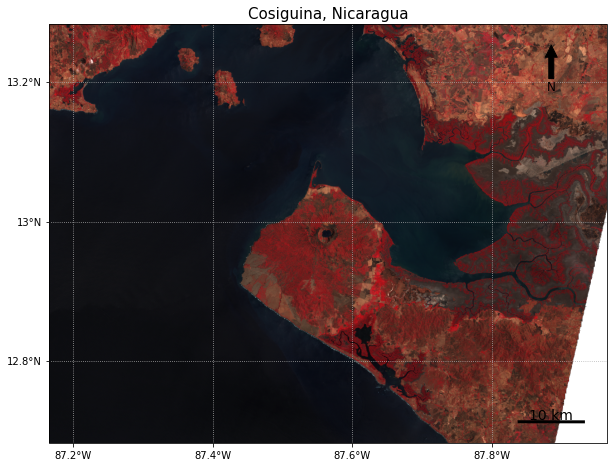

In [ ]:
# Ploteo cartográfico

from geemap import cartoee
lat= 12.983
lon= -87.565
w = 0.4
h = 0.3

region = [lon - w, lat - h, lon + w, lat + h]

fig = plt.figure(figsize=(10, 8))

# use cartoee to get a map
ax = cartoee.get_map(image, region=region, vis_params=vis_params)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.2, 0.2], linestyle=":")

# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.9, 0.95),
    "arrow_length": 0.10,
    "text_color": "black",
    "arrow_color": "black",
    "fontsize": 12,
    "width": 5,
    "headwidth": 12,
    "ha": "center",
    "va": "center",
}
cartoee.add_north_arrow(ax, **north_arrow_dict)

# add scale bar
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 14,
    "color": "black",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}
cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

ax.set_title(label='Cosiguina, Nicaragua', fontsize=15)

plt.show()

In [ ]:
import os
cartoee.get_image_collection_gif(
    ee_ic=collection,
    out_dir=os.path.expanduser("~/Downloads/timelapse"),
    out_gif="animation.gif",
    vis_params=vis_params,
    region=region,
    fps=1,
    mp4=True,
    grid_interval=(0.2, 0.2),
    plot_title="Consiguina, Nicaragua",
    date_format='YYYY-MM-dd',
    fig_size=(10, 8),
    dpi_plot=200,
    file_format="png",
    #north_arrow_dict=north_arrow_dict,
    scale_bar_dict=scale_bar_dict,
    verbose=True,
)

GIF saved to /root/Downloads/timelapse/animation.gif
MP4 saved to /root/Downloads/timelapse/animation.mp4


# Final

Acá finaliza el manual introductoria a GEE con Geemap

Para dudas o consultas comunicarse con el equipo RAC. 

Para más tutoriales puede visitar el canal de Youtube del creador de geemap Qiusheng Wu  https://www.youtube.com/@giswqs

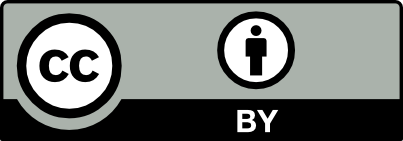